# Cost prediction

## Description / Goal

Goal: Create a cost predictive model to predict the execution time of a simulation for an approximation rate thanks to features (here number of cells in the matrix representing the geographical site) regarding that simulation. The end goal is to define the approximation factor to use for that simulation to match a defined execution budget (i.e., execution time).


## Import libraries

In [1]:
import os
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statistics
from sklearn import metrics
random.seed(42)

## Functions to load 

In [2]:
def retrieve_list_cases_and_split_data_BVE(data_complete, sites_completes, ratio_train):
    #Computing the number of sites that are used for the training
    training_nb_cases = round(len(sites_completes) * ratio_train)

    # Selecting the sites for the training and testing sets : Random Selection
    training_cases = random.sample(sites_completes.tolist(), training_nb_cases)
    testing_cases = [x for x in sites_completes.tolist() if x not in training_cases]
    
    # Retrieving the dataset for the training phase
    data_train = extract_data_from_list_of_sites(data_complete, training_cases)
    
    # Retrieving the dataset for the testing phase
    data_test = extract_data_from_list_of_sites(data_complete, testing_cases)

    return data_train, data_test, training_cases, testing_cases

In [3]:
def extract_data_from_list_of_sites(data_complete, cases):
    data_cases = pd.DataFrame(columns=data_complete.columns)
    for case in cases:
        data_case = data_complete.loc[(data_complete['SiteNumber'] == case)]
        data_cases = pd.concat([data_cases, data_case], sort=False)
        
    return data_cases

In [4]:
def extract_features_and_outputs_datasets_BVE(data_train, data_test, features):
    # load names of all the features contained in the dataset to extract the data we want
    global all_features
    
    # Create in- and output data for the training phase
    X_train, y_train = create_input_and_output_datasets_for_time(data_train)
    
    # Create in- and output data for the testing phase
    X_test, y_test = create_input_and_output_datasets_for_time(data_test)
    
    #Remove all the unnecessary features in the input datasets
    features_to_remove = [feature for feature in all_features if feature not in features]
    for feature in features_to_remove:
        del X_train[str(feature)]
        del X_test[str(feature)]

    return X_train, y_train, X_test, y_test 

In [5]:
def create_input_and_output_datasets_for_time(data):
    y_data = data.filter(["SiteNumber", "Time"], axis=1)
    X_data = data.drop(["Chronicle", "Validation Metric", "Accuracy", "Time"], axis=1)
    del y_data["SiteNumber"]
    del X_data["SiteNumber"]
    return X_data, y_data

In [6]:
def train_forest(X_train, y_train):
    forest = RandomForestRegressor(
        n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1, oob_score = True, bootstrap = True
    )
    forest.fit(X_train, y_train.values.ravel())

    return forest

In [7]:
def compute_standard_metrics(y_test, y_test_pred):

    mse = mean_squared_error(y_test.values.ravel(), y_test_pred)
    r2 = r2_score(y_test.values.ravel(), y_test_pred)
    rmse = metrics.mean_squared_error(y_test.values.ravel(), y_test_pred, squared=False)

    return mse, r2, rmse

In [8]:
def update_and_store_data_with_time_pred(path, data_test, y_test, y_test_pred, testing_cases):
    suffixe = "_".join(map(str,list(map(int, sorted(testing_cases)))))
    data_test = data_test.assign(Timetest=y_test.values.ravel())
    data_test = data_test.assign(TimePred=y_test_pred)
    
    data_test.to_csv(os.path.join(path,"data/Output_Data/Data_Test_With_Time_pred_Rates_" + str(nb_rates) + "_Features_" + str('_'.join(features)) + "_" + str(scale)  + "_" + str(suffixe) + ".csv"), index=False, sep=";")
    return data_test

In [9]:
def normalise_dataset_for_time_data(df_data):
    df_data["Time"] = (df_data["Time"]-df_data["Time"].min())/(df_data["Time"].max()-df_data["Time"].min())
    return df_data

# Evaluation Pipeline

## Parameters

In [10]:
path = os.path.abspath(os.path.join(os.path.abspath(""), os.pardir))
nb_rates = 30
chronicle = 0
scale = "BVE"
ratio_train = 0.8

# Different sets of features 
set_geomorph = ["Slope", "Elevation", "LC", "CW", "Area"]
set_CVHV = ["Coastal Vulnerability", "Hydrological Vulnerability"]
set_saturation= ["Satured Zone Area", "Vulnerability Sum", "Vulnerability Rate"]
set_cells = ["Number of Cells"]
all_features = set_geomorph + set_CVHV + set_saturation + set_cells

# We select the type of features we want to use for training our model
features = set_cells
print(features)

['Number of Cells']


## Pipeline

In [11]:
def pipeline_pred_time(path, nb_rates, features, scale, ratio_train):
    df_data = pd.read_csv(os.path.join(path, "data/", "Input_Data_Time_ValidMetric_Features_Rates_" + str(nb_rates) + "_Features_" + "Geomorph_CVHV_Saturation_Cells" + "_" + str(scale) + "_Comparable.csv"), sep=";")
    #Normalisation of the data
    df_data = normalise_dataset_for_time_data(df_data)
    sites_completes = df_data.SiteNumber.unique()
    data_train, data_test, training_cases, testing_cases = retrieve_list_cases_and_split_data_BVE(df_data, sites_completes, ratio_train)
    X_train, y_train, X_test, y_test = extract_features_and_outputs_datasets_BVE(data_train, data_test, features)
    forest = train_forest(X_train, y_train)
    y_test_pred = forest.predict(X_test)
    print('scores')
    mse, r2, rmse = compute_standard_metrics(y_test, y_test_pred)
    #print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R2: ", r2)
    data_test = update_and_store_data_with_time_pred(path, data_test, y_test, y_test_pred, testing_cases)
    return mse, r2, rmse

## Replication of elaboration of the cost predictive model : x 25

In [12]:
scores_mse = []
scores_rmse = []
scores_r2 = []
for i in range(25):
    print("Replication:", i+1)
    mse, r2, rmse = pipeline_pred_time(path, nb_rates, features, scale, ratio_train)
    #scores_mse.append(mse)
    scores_rmse.append(rmse)
    scores_r2.append(r2)
    print("----------")

Replication: 1
scores
RMSE:  0.025035210452707273
R2:  0.9097126466145888
----------
Replication: 2
scores
RMSE:  0.025143655712542203
R2:  0.9559294844689207
----------
Replication: 3
scores
RMSE:  0.02014063256141532
R2:  0.9740434946105913
----------
Replication: 4
scores
RMSE:  0.014402663677047223
R2:  0.9627420568602884
----------
Replication: 5
scores
RMSE:  0.02073010862362068
R2:  0.9558199959754341
----------
Replication: 6
scores
RMSE:  0.022243149761954246
R2:  0.965298823081712
----------
Replication: 7
scores
RMSE:  0.019053621902767662
R2:  0.9756471291706214
----------
Replication: 8
scores
RMSE:  0.017127624470133024
R2:  0.9817758395192496
----------
Replication: 9
scores
RMSE:  0.031651265378463495
R2:  0.8689505406419082
----------
Replication: 10
scores
RMSE:  0.022250559433108483
R2:  0.9349943536035269
----------
Replication: 11
scores
RMSE:  0.015218849779625971
R2:  0.980834945999041
----------
Replication: 12
scores
RMSE:  0.02271374995798538
R2:  0.9492417338

## Get statistics of scores

### RMSE

In [13]:
print("Mean:", statistics.mean(scores_rmse), ", Median:", statistics.median(scores_rmse))
print("Min:", min(scores_rmse), ", Max:", max(scores_rmse), ", Std:", statistics.stdev(scores_rmse))

Mean: 0.021600140812664256 , Median: 0.022243149761954246
Min: 0.013324141118359683 , Max: 0.031651265378463495 , Std: 0.0052458414337176185


### R2

In [14]:
print("Mean:", statistics.mean(scores_r2), ", Median:", statistics.median(scores_r2))
print("Min:", min(scores_r2), ", Max:", max(scores_r2), ", Std:", statistics.stdev(scores_r2))

Mean: 0.9552316186902013 , Median: 0.9584102444900615
Min: 0.8689505406419084 , Max: 0.9910698183409015 , Std: 0.025275860641204115


## Plotting the scores

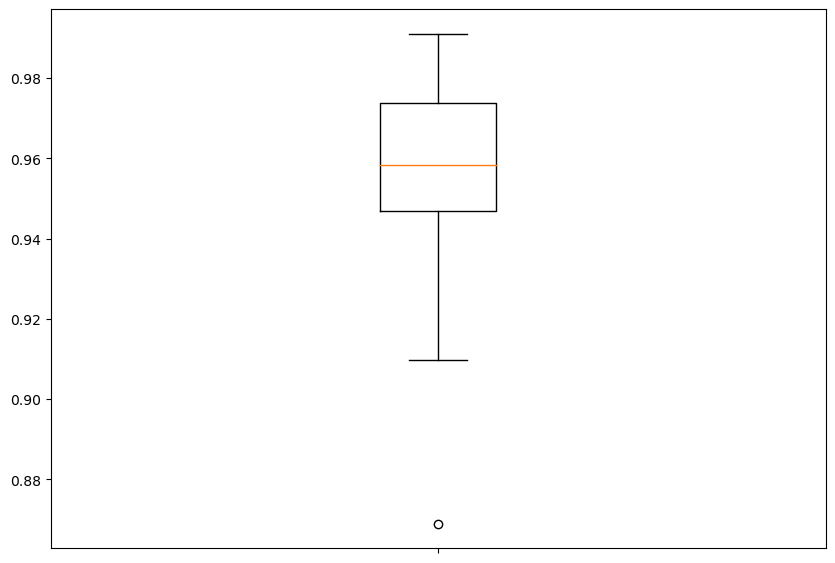

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(scores_r2)
plt.xticks([1], [""])
 
# show plot
#plt.show()
plt.savefig('Scores_r2_25Repetitions.pdf')